In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [32]:
#Dataset
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2022-10-04 15:20:27--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 208.110.86.68
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|208.110.86.68|:443... failed: Unknown error.
Retrying.

--2022-10-04 15:20:50--  (try: 2)  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|208.110.86.68|:443... failed: Unknown error.
Retrying.

--2022-10-04 15:21:13--  (try: 3)  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|208.110.86.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: 'AER_credit_card_data.csv.3'

     0K .......... .......... .......... .......... .......... 69% 76.3K 0s
    50K 

In [39]:
#Preparation

df = pd.read_csv('AER_credit_card_data.csv')
df.columns = df.columns.str.lower()

In [52]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,1,0,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,0,0,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,1,0,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,0,0,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,1,0,2,64,1,5


In [41]:

card_values = {
    'yes': 1 ,
    'no': 0
}

df.card = df.card.map(card_values)


owner_values = {
    'yes': 1 ,
    'no': 0
}

df.owner = df.owner.map(owner_values)

selfemp_values = {
    'yes': 1 ,
    'no': 0
}

df.selfemp = df.selfemp.map(selfemp_values)

In [53]:
numerical = ['reports', 'age', 'income', 'share', 'expenditure',
             'dependents', 'months', 'majorcards', 'active']
categorical = ['owner', 'selfemp']

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = \
        train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

In [56]:
#Question 1

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [57]:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

  reports, 0.717
      age, 0.524
   income, 0.591
    share, 0.989
expenditure, 0.991
dependents, 0.533
   months, 0.529
majorcards, 0.534
   active, 0.604


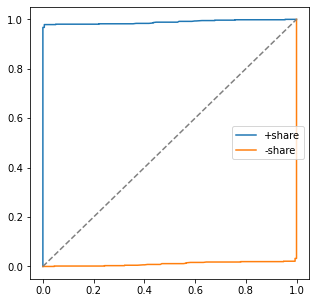

In [59]:
# plot the ROC curve for share

plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.share)
plt.plot(fpr, tpr, label='+share')

fpr, tpr, _ = roc_curve(y_train, -df_train.share)
plt.plot(fpr, tpr, label='-share')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

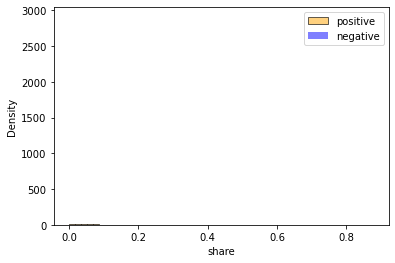

In [60]:
sns.histplot(df_train.share[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(df_train.share[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

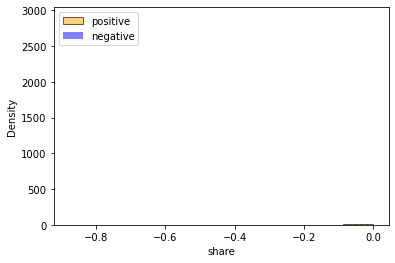

In [61]:
sns.histplot(-df_train.share[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(-df_train.share[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

In [62]:
#Training the model

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [63]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [65]:
#Question 2

round(roc_auc_score(y_val, y_pred), 3)


0.995

In [67]:
y_pred_bin = model.predict(X_val)
round(roc_auc_score(y_val, y_pred_bin), 3)

0.974

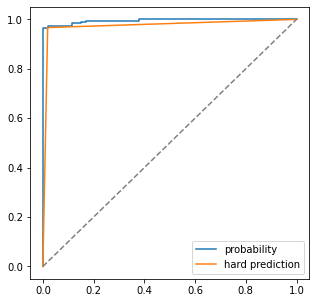

In [68]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

In [69]:
#Question 3

def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [70]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

In [71]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,211,53,0,0
10,0.1,210,17,1,36
20,0.2,206,6,5,47
30,0.3,205,3,6,50
40,0.4,204,1,7,52
50,0.5,204,1,7,52
60,0.6,204,1,7,52
70,0.7,204,1,7,52
80,0.8,204,1,7,52
90,0.9,204,0,7,53


In [72]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

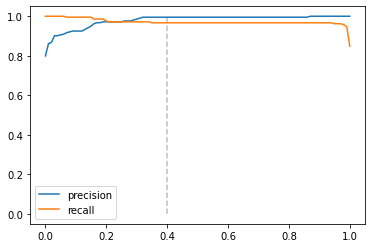

In [73]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.4, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

In [85]:
#Question 4

df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

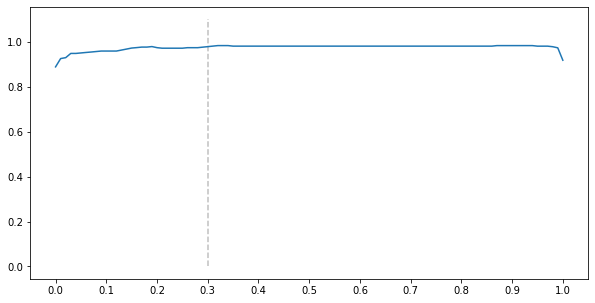

In [95]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.3, 0, 1.1, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [96]:
#Question 5

from sklearn.model_selection import KFold


In [97]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [99]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


In [101]:
#Question 6

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.992 +- 0.006
C= 0.1, 0.994 +- 0.005
C=   1, 0.996 +- 0.003
C=  10, 0.997 +- 0.003
